# Iris Plant Classification

Based on the Fisher Iris dataset https://archive.ics.uci.edu/dataset/53/iris. This dataset, from Fisher (1936), is a commonly known dataset used to test classification methods. It is composed by 3 classes, with each containing 50 instances, with each instance being a plant. The prediction expected is to classifiy each plant in a type of iris plant. 

In [130]:
# Code available in the https://archive.ics.uci.edu/dataset/53/iris web page
# Optional to run, another implementation (below) was used

from ucimlrepo import fetch_ucirepo 
  
iris = fetch_ucirepo(id=53) 
  
X = iris.data.features 
y = iris.data.targets


### Library Imports

In [131]:
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np

### Data Fetching

The previous method is suggested in the website. However, to reduce the number of libraries used, the data is imported using the CSV file available.

In [132]:
data_path = "data/data.csv"
iris = pd.read_csv(data_path)
X = iris.iloc[:,0:iris.shape[1] - 1].to_numpy()
y = iris.iloc[:,iris.shape[1] - 1].to_numpy()

### Data Visualization

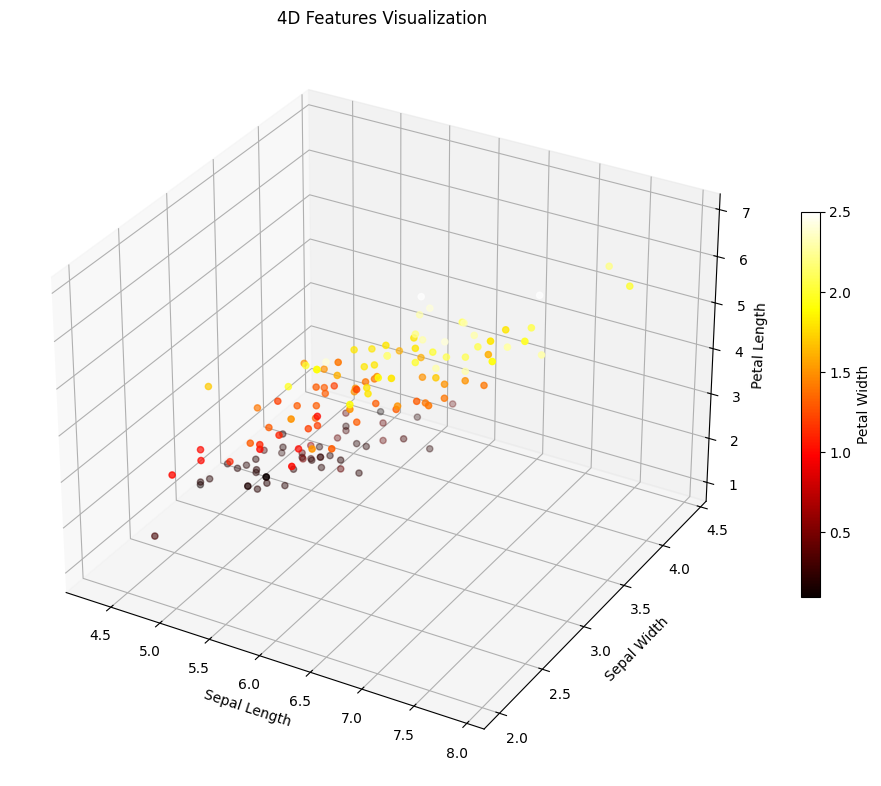

<Axes: title={'center': 'Classes Count'}, xlabel='Possible Classifications'>

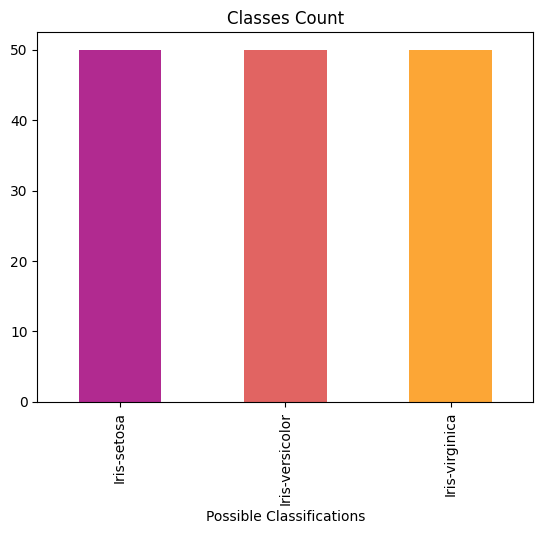

In [133]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(projection='3d')
img = ax.scatter(X[:,0], X[:,1], X[:,2], c=X[:,3], cmap=plt.hot())
ax.set_title("4D Features Visualization")
ax.set_xlabel('Sepal Length')
ax.set_ylabel('Sepal Width')
ax.set_zlabel('Petal Length')
ax.zaxis.labelpad=0
fig.colorbar(img, shrink=0.5, label="Petal Width")
plt.show()

classes_list = list(np.unique(y))
classes_num = len(classes_list)
color = mpl.colormaps['plasma'](np.linspace(.4, .8, classes_num)) 
iris.iloc[:,-1].value_counts().plot(kind="bar", color=color, title="Classes Count", xlabel="Possible Classifications")

### Data Preprocessing
The results in the previous cell shown a uniform distribution of classes. Therefore, these are now going to be split in train and test and label encoded, as well as uniformization.

In [146]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Uniformization 
X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)

# Label Encoding
class_codes = []
for class_name in iris.iloc[:,-1]:
    class_code = classes_list.index(class_name)
    class_codes.append(class_code)
y = np.array(class_codes)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.20, shuffle=True, stratify=y)

### K-Folds Validation

K-Folds is commonly used in datasets with a small quantity of data, to avoid keeping a part of the set only for validation.

In [147]:
k = 10 # Number of folds

fold_size = len(X_train) // k
indices = np.arange(len(X_train))
fold_indices = [] 
for i in range(k):
    val_indices = indices[i * fold_size: (i + 1) * fold_size] 
    train_indices = np.concatenate([indices[:i * fold_size], indices[(i + 1) * fold_size:]])
    fold_indices.append((train_indices, val_indices))

### Model's Application

Decision Tree Mean Accuracy: 0.925


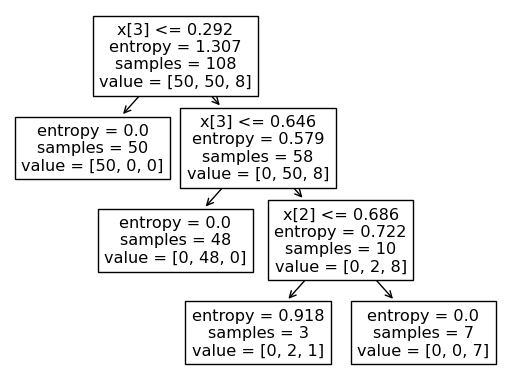

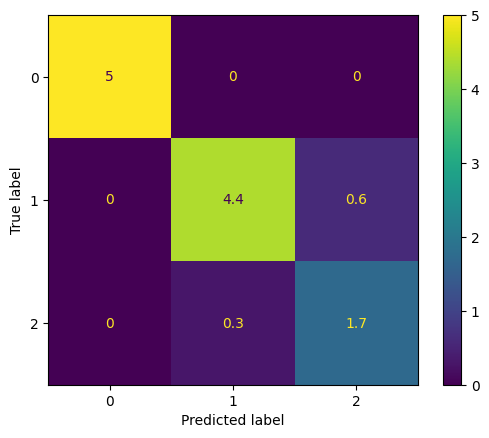

<Figure size 1200x800 with 0 Axes>

In [153]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay 

models = {
    "Logistic Regression": LogisticRegression(solver='lbfgs', max_iter=1000, penalty="l2", tol=1e-6, C=1),
    # The solver selected showed best results. Tolerance was decreased to compensate the random initialization of C, 
    # forcing more consistent results. The number of iterations was increased since with 100 (the default value), 
    # since the model was still converging whilst reaching the said limit
    "Decision Tree": DecisionTreeClassifier(criterion="log_loss", max_depth=3, min_samples_leaf=1),
    # max_depth was defined as 3 to prevent overfitting and min_samples_leaf was considered 1 because the number
    # of classes in this problem is small. log_loss was chosen since it presents the best results
    # "Random Forest": RandomForestClassifier(random_state=42), 
    # "SVM": SVC(),
    # "Gaussian Naive-Bayes": GaussianNB()
}

X_original = X
y_original = y

for model_name in models:
    model = models[model_name]
    accuracies = []
    cm_list = [] 
    X = X_original
    Y = y_original

    for train_indices, val_indices in fold_indices:
        X_train, Y_train = X[train_indices], Y[train_indices]
        X_val, Y_val = X[val_indices], Y[val_indices] 
        model.fit(X_train, Y_train) 
        Y_pred = model.predict(X_val)
        accuracies.append(accuracy_score(Y_val, Y_pred))
        cm_list.append(confusion_matrix(Y_val, Y_pred, labels=[0, 1, 2]))

    accuracy_mean = np.mean(accuracies) 
    cm_mean = np.mean(cm_list, axis=0) 
    print(model_name, "Mean Accuracy:", accuracy_mean) 

    if(model_name == "Decision Tree"):
        plot_tree(model)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm_mean)
    disp.plot()
    plt.figure(figsize=(12,8))
    plt.show()